## 2. DATASETS & DATALOADERS
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

데이터 processing을 할 때, 코드가 지저분하고 유지하기 어려울 수 있다.  
여기서는 Dataset 코드를 모델 training code를 decoupling 하여, 더 읽기 쉽고 모듈화하도록 만든다.  
이러한 유지보수와 가독성을 위해 pytorch에서는 torch.utils.data.DataLoader와 torch.utils.data.Dataset을 제공한다.  
이 기능은 Dataset을 pre-load하여 사용할 수 있게 해준다.  
작동 방식은 Dataset이 sample과 label을 저장하면, DataLoader가 이걸 iterable하게 감싸서 sampling하기 쉽게 만들어주는 식으로 작동한다.

`-` 사용자 파일에서 Custom Dataset 만들기

Custom Dataset class를 만들 때, 반드시 구현해야할 3가지 함수가 있는데, 다음과 같다. 설명은 아래 코드와 함께 보자.
- __init__: Custom Dataset의 instance를 만들면 처음에 자동으로 실행되는 함수이다. 아래 코드로 보자면, 이 함수는 처음 instance가 만들어졌을 때, image의 directory를 불러오고 annotation file, transforms를 처음에 설정한다.
- __len__: 이 함수는 데이터의 개수를 반환한다. len(list 데이터)와 같은 역할이다.
- __getitem__: 인덱싱을 통하여 데이터를 불러와주도록 하는 기능을 한다.

In [10]:
import torch
from torch.utils.data import Dataset

In [3]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

`-` Model training을 위한 DataLoaders

Dataset은 Dataset의 feature와 label을 하나씩 샘플링한다. 하지만 model training을 할 때를 보면, 
1. 보통 우리는 `minibatch` 형태로 샘플링을 해서 model에 입력을 준다. 
2. 또, model의 overfitting을 줄이기 위해, 매 epoch마다 배치를 shuffle 하면서 입력으로 mini batch를 넣어준다.
3. Python의 multiprocessing을 사용하여 data retrieval 속도를 높이는 옵션도 고려할 수 있다.

DataLoader는 이렇게 유용하면서 직접 구현하기 복잡한 기능들을 abstract하게 만들어 사용자 입장에서 쉬운 API로 사용할 수 있게 해주는 iterable 객체이다.
- iterable 객체: 반복 가능한 객체. 대표적인 iterable한 타입으로 list, dict, set, str, bytes, tuple, range 가 있다. (출처: https://wikidocs.net/16068)




DataLoader는 아래와 같은 형식으로 구현 가능하다.
- 아래 train_data는 Dataset에서 제공하는 Fashion MNIST 데이터를 불러온 것이다.

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Dataset을 DataLoader로 load를 하면, dataset을 iterate할 수 있게된다. 각각 DataLoader의 인자들은,
- training_data: Dataset
- batch_size: mini-batch의 크기
- suffle: 매 epoch마다 데이터 suffle의 유무
- Data loader의 iteration마다 반환 형식은 ([1 번째 train_feature, 2 번째 train_feature, ..., 64 번째 train_feature], [1 번째 label, 2 번째 train_label, ..., 64 번째 train_label]) 과 같이 feature와 label 따로 반환된다.
    - train_features, train_labels = next(iter(train_dataloader)) 와 같이 feature와 label을 따로 저장할 수 있다.



Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


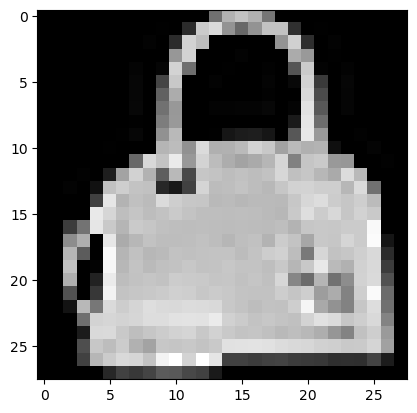

Label: 8


In [9]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader)) # 64개의 batch 이미지, 라벨 반환.
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze() # sampling한 64개의 이미지 batch에서 첫 번째 이미지 반환
label = train_labels[0] # sampling한 64개의 라벨 batch에서 첫 번째 라벨 반환
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")